In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import least_squares as lsq
import random
random.seed(4321)
np.random.seed(1234)

In [2]:
PolRel = pd.read_excel("Seshat_PolityRelationData.xlsx")
Data = pd.read_csv("Seshat Data.csv")
Parameters_and_Times = np.loadtxt("Parameters_and_Times.txt")
RelTimeDF = pd.read_csv("RelTime_TimeSeries_SPC1.csv", index_col = 0)
RelTimeCCDF = pd.read_csv("RelTime_TimeSeries_CC.csv")
Parameters = Parameters_and_Times[:4]
Times = Parameters_and_Times[4:]
T = 5000

In [3]:
RelTimeDF.shape

(771, 3)

In [4]:
def f(x, a, b, c, d):
    # the logistic function in its most general shape, scaled by T=5000
    return a / (1. + np.exp(-c * (x - d))) + b

In [5]:
del RelTimeCCDF["Unnamed: 0"]

In [6]:
set(Data["NGA"]).issubset(set(PolRel["NGA"]))

True

In [7]:
# Discard superfluous NGAs
SubsetNGA = np.array(PolRel["NGA"].isin(set(Data["NGA"])))
PolRel = PolRel.iloc[SubsetNGA]


In [8]:
PolRel.head(50)

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
21,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland II,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [9]:
for i in list(set(PolRel["Dupl"])):
    print(i,sum(PolRel["Dupl"] == i))

y 103
n 596


In [10]:
# relationship to preceding (quasi)polity

for v in list(set(PolRel["Variable"])):
    print(v, sum(PolRel["Variable"]==v))

# Logical for Variable is the relationship
VR = PolRel["Variable"] == "relationship to preceding (quasi)polity"

Previous = PolRel.loc[np.logical_not(VR)]
Relationships = PolRel.loc[VR]

succeeding (quasi)polity 364
relationship to preceding (quasi)polity 335


In [11]:
Previous.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN


In [12]:
Relationships.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
23,Cahokia,USMisMu,Cahokia - Late Woodland II,450.0,600.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [13]:
for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )
                

contination 1
cultural assimilation 25
continunity 4
not applicable 2
continuation 7
indigenous revolt 1
population migration 13
continuity 228
vassalage 1
Continuation 1
Continuity 9
replacement 1
suspected unknown 2
elite migration 40


In [14]:
# Ever

Relationships["Value.From"].replace("Continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continunity", "continuity", inplace = True)
Relationships["Value.From"].replace("contination", "continuity", inplace = True)
Relationships["Value.From"].replace("Continuity", "continuity", inplace = True)

                
for val in list(set(Relationships["Value.From"])):
    if val != "continuity":
        Relationships["Value.From"].replace(val, "discontinuity", inplace = True)

for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )    

continuity 250
discontinuity 85


C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [15]:
CleanRel = pd.concat((Previous,Relationships), sort=False).sort_index()

In [16]:
CleanRel.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN


In [17]:
TimeZero = pd.read_csv("TimeZero.csv")
TimeZero.head()

,Unnamed: 0,Paris Basin,Yemeni Coastal Plain,Susiana,Orkhon Valley,Latium,Kansai,Cambodian Basin,Sogdiana,Central Java,Cuzco,Ghanaian Coast,Deccan,Konya Plain,Middle Yellow River Valley,Niger Inland Delta,Upper Egypt,Kachi Plain,Iceland
0,T0,-200,400,-3700,500,-700,400,300,-500,800,1400,1800,-300,-2000,-1800,1000,-3100,-2500,1300


In [18]:

# Again Discard superfluous NGAs
SubsetNGA_2 = np.array(Relationships["NGA"].isin(set(TimeZero.columns)))
Relationships = Relationships.iloc[SubsetNGA_2]

set(Relationships["NGA"]).issubset( set(TimeZero.columns))


True

In [19]:
Relationships["Polity.Start.Scaled"] = 0

# iterate over all rows in the DF
for i in range(Relationships.shape[0]):
    n = Relationships["NGA"].iloc[i]
    
    # for this NGA: read its Time_Zero from the TimeZero.csv
    T_zero = TimeZero[n]
    # Shift the time accordingly
    Relationships["Polity.Start.Scaled"].iloc[i] = Relationships["Polity.Start"].iloc[i] - T_zero
    

C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [20]:
from scipy.stats import gaussian_kde
KDE = gaussian_kde(Relationships["Polity.Start.Scaled"])
time_range = np.arange(-6000,6000,10)
KDE_t = KDE(time_range)

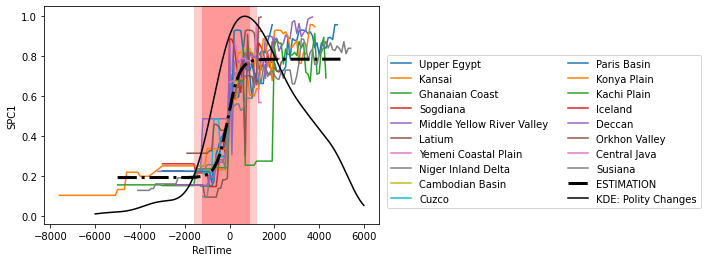

In [21]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE: Polity Changes")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)


plt.show()

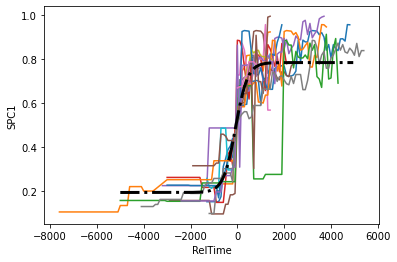

In [22]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
#plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
#plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
#plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
#plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE: Polity Changes")

#plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.savefig("FullLogistic.pdf", dpi=200, bbox_inches="tight")
plt.show()

## Normalise the Number of Polity Changes

Divide it by the number of existing polities at RelTime T, because if there are only few polities at an early time, we would also only expect few possible polity changes.

In [23]:
T_min, T_max = min(RelTimeDF["RelTime"]), max(RelTimeDF["RelTime"])

In [24]:
NumberPol = pd.DataFrame(columns=["RelTime", "NumberPol"])
for t in np.arange(T_min, T_max+100, 100):
    #print(t)
    #print(sum(RelTimeDF["RelTime"]==t))
    NumberPol = pd.concat([NumberPol,
                         pd.DataFrame({"RelTime": [t],
                                      "NumberPol": [sum(RelTimeDF["RelTime"]==t)]})])
NumberPol

,RelTime,NumberPol
0,-7600,1
0,-7500,1
0,-7400,1
0,-7300,1
0,-7200,1
...,...,...
0,5000,1
0,5100,1
0,5200,1
0,5300,1


In [25]:
NumberPol["NumberPol"].loc[NumberPol["RelTime"]==1000]

0    13
Name: NumberPol, dtype: object

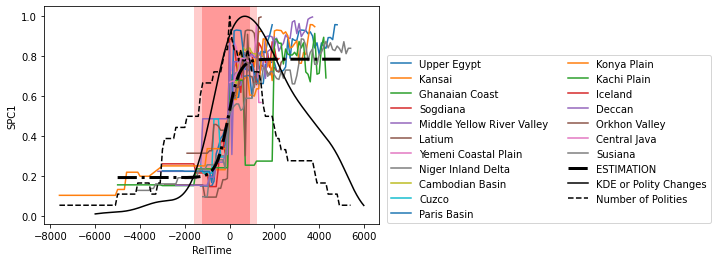

In [26]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE or Polity Changes")

plt.plot(NumberPol["RelTime"], NumberPol["NumberPol"]/np.max(NumberPol["NumberPol"]), "--", c="k",
        label="Number of Polities")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.show()

## Deal with the Continuity of Polities

In [27]:
 # this DF tells is, if a polity in an NGA is continuous or not
print(Relationships)
print(sorted(list(set(Relationships["NGA"])))) # only the long-lived ones remain

                      NGA    PolID               Longform.Name  Polity.Start  \
42        Cambodian Basin  KhFunaE                     Funan I         225.0   
44        Cambodian Basin  KhFunaL                    Funan II         540.0   
46        Cambodian Basin  KhChenl                      Chenla         550.0   
49        Cambodian Basin  KhAngkE                Early Angkor         802.0   
51        Cambodian Basin  KhAngkC            Classical Angkor        1100.0   
..                    ...      ...                         ...           ...   
830           Upper Egypt  TrOttm3           Ottoman Empire II        1517.0   
834           Upper Egypt  TrOttm4          Ottoman Empire III        1683.0   
858  Yemeni Coastal Plain  YeQasmi     Yemen - Qasimid Dynasty        1637.0   
861  Yemeni Coastal Plain  TrOttm4          Ottoman Empire III        1683.0   
862  Yemeni Coastal Plain  YeOttoL  Ottoman Empire Late Period        1873.0   

     Polity.End Dupl            Section

In [28]:
print(Relationships[["NGA", "Polity.Start.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"].iloc[50:70])

             NGA  Polity.Start.Scaled
580     Sogdiana               -250.0
587     Sogdiana                371.0
593     Sogdiana                908.0
606     Sogdiana               1450.0
699      Susiana               1430.0
708      Susiana               2200.0
710      Susiana               2301.0
713      Susiana               2501.0
726      Susiana               3453.0
744      Susiana               4632.0
745      Susiana               4632.0
746      Susiana               4737.0
747      Susiana               4737.0
754      Susiana               4956.0
756      Susiana               4956.0
757      Susiana               5039.0
764      Susiana               5201.0
765      Susiana               5494.0
784  Upper Egypt               2031.0
788  Upper Egypt               2436.0


In [29]:
Breakpoints = Relationships[["NGA", "Polity.Start.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"]
Breakpoints.columns = ["NGA", "RelTime"]
Breakpoints.head()

,NGA,RelTime
67,Central Java,492.0
138,Cuzco,-900.0
142,Cuzco,-750.0
145,Cuzco,-400.0
149,Cuzco,-25.0


In [30]:
for t in Breakpoints[Breakpoints.NGA=="Latium"].RelTime:
    print(t)

669.0
1411.0


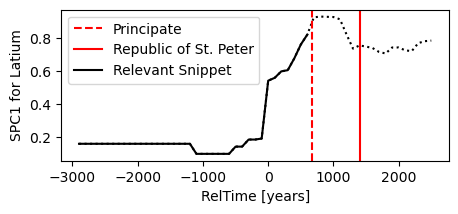

In [31]:
plt.figure(figsize =(5,2), dpi=100)
DF = RelTimeDF[RelTimeDF["NGA"]=="Latium"] # no reltime
plt.plot(DF["RelTime"], DF["SPC1"], c="k", linestyle =":")

L = "Principate"
colour ="red"
style="--"
for t in Breakpoints[Breakpoints.NGA=="Latium"].RelTime:
    plt.axvline(t,label=L,
                c = colour,
                linestyle = style )
    L = "Republic of St. Peter"
    style = "-"

UpTo = Breakpoints[Breakpoints.NGA=="Latium"].RelTime.iloc[0]

DF = DF.query("RelTime<@UpTo")

plt.plot(DF["RelTime"], DF["SPC1"], c="k", linestyle="-",label="Relevant Snippet")

    
    
    
plt.legend()
plt.xlabel("RelTime [years]")
plt.ylabel("SPC1 for Latium")

plt.savefig("Latium_Discontinuities.pdf",dpi=200, bbox_inches='tight')
plt.show()

In [32]:
Breakpoints[Breakpoints.NGA=="Latium"].RelTime.iloc[0]

669.0

In [33]:
# Get the snippet that includes RelTime=0 and does not have any discontinuity
def Cutout(nga, df = RelTimeDF):
    
    
    Output = df.loc[df["NGA"]==nga]
    
    # if the nga has a discontinuous breakpoint, we need to cut out the central part of Output around 0
    if nga in set(Breakpoints["NGA"]):
        
        # get this nga's breakpoints
        BPs = Breakpoints.loc[Breakpoints["NGA"] == nga]
        
        
        # isolate the first breakpoint above zero
        # NOT exactly zero, because a breakpoint at zero means that up to RelTime 0, the polity has changed
        BP_positive = BPs.loc[BPs["RelTime"] > 0]
        
        if BP_positive.shape[0]>0: # is there any Breakpoint after 0?
            BP_end = min(BP_positive["RelTime"])
        else:
            BP_end = np.infty # else: latest possible year
        
        # Now need the beginning of the cutout-area, i.e. the last breakpoint before BP_end
        BP_rest = BPs.loc[BPs["RelTime"] < BP_end]
        
        
        if BP_rest.shape[0] > 0: # is there even a breakpoint before this?
            BP_start = max(BP_rest["RelTime"])
        else:
            BP_start = -np.inf # else: set the earliest possible time as beginning for the cutout
    
        print("BPs",BPs)
        print(BP_start,BP_end)
        
        Output = Output.loc[Output["RelTime"] > BP_start-1 ]
        Output = Output.loc[Output["RelTime"] < BP_end +1 ]
        
    return(Output)

In [34]:
## Test
Cutout_DF = pd.DataFrame(columns = RelTimeDF.columns)
Cutout_CCDF = pd.DataFrame(columns = RelTimeCCDF.columns)

for n in list(set(RelTimeDF["NGA"])):
    print(Cutout(n))
    Cutout_DF = pd.concat((Cutout_DF, Cutout(n)))
    Cutout_CCDF = pd.concat((Cutout_CCDF, Cutout(n, RelTimeCCDF)))

BPs              NGA  RelTime
784  Upper Egypt   2031.0
788  Upper Egypt   2436.0
791  Upper Egypt   2696.0
797  Upper Egypt   3069.0
819  Upper Egypt   4009.0
-inf 2031.0
             NGA  RelTime      SPC1
660  Upper Egypt    -1300  0.151832
661  Upper Egypt    -1200  0.151832
662  Upper Egypt    -1100  0.151832
663  Upper Egypt    -1000  0.151832
664  Upper Egypt     -900  0.151832
665  Upper Egypt     -800  0.151832
666  Upper Egypt     -700  0.174698
667  Upper Egypt     -600  0.312390
668  Upper Egypt     -500  0.348164
669  Upper Egypt     -400  0.389162
670  Upper Egypt     -300  0.405380
671  Upper Egypt     -200  0.440667
672  Upper Egypt     -100  0.446454
673  Upper Egypt        0  0.587768
674  Upper Egypt      100  0.587768
675  Upper Egypt      200  0.585601
676  Upper Egypt      300  0.594301
677  Upper Egypt      400  0.595334
678  Upper Egypt      500  0.700498
679  Upper Egypt      600  0.700498
680  Upper Egypt      700  0.700498
681  Upper Egypt      800  0.703383


BPs              NGA  RelTime
521  Paris Basin  -3000.0
533  Paris Basin   -275.0
540  Paris Basin    169.0
541  Paris Basin    169.0
542  Paris Basin    169.0
543  Paris Basin    169.0
544  Paris Basin    169.0
552  Paris Basin    681.0
-275.0 169.0
             NGA  RelTime      SPC1
750  Paris Basin     -200  0.356129
751  Paris Basin     -100  0.451406
752  Paris Basin        0  0.499567
753  Paris Basin      100  0.554045
BPs              NGA  RelTime
521  Paris Basin  -3000.0
533  Paris Basin   -275.0
540  Paris Basin    169.0
541  Paris Basin    169.0
542  Paris Basin    169.0
543  Paris Basin    169.0
544  Paris Basin    169.0
552  Paris Basin    681.0
-275.0 169.0
BPs              NGA  RelTime
521  Paris Basin  -3000.0
533  Paris Basin   -275.0
540  Paris Basin    169.0
541  Paris Basin    169.0
542  Paris Basin    169.0
543  Paris Basin    169.0
544  Paris Basin    169.0
552  Paris Basin    681.0
-275.0 169.0
BPs              NGA  RelTime
294  Konya Plain  -1000.0
317  Konya 

In [35]:
Cutout_DF, Cutout_CCDF


(             NGA RelTime      SPC1
 660  Upper Egypt   -1300  0.151832
 661  Upper Egypt   -1200  0.151832
 662  Upper Egypt   -1100  0.151832
 663  Upper Egypt   -1000  0.151832
 664  Upper Egypt    -900  0.151832
 ..           ...     ...       ...
 51       Susiana    1000  0.589980
 52       Susiana    1100  0.664407
 53       Susiana    1200  0.664407
 54       Susiana    1300  0.664407
 55       Susiana    1400  0.664407
 
 [368 rows x 3 columns],
              NGA RelTime      SPC1    PolPop   PolTerr    CapPop    levels  \
 325  Upper Egypt   -1300  0.151832  2.155355  3.469650  1.825388  1.069413   
 326  Upper Egypt   -1200  0.151832  2.155355  3.469650  1.825388  1.069413   
 327  Upper Egypt   -1100  0.151832  2.155355  3.469650  1.825388  1.069413   
 328  Upper Egypt   -1000  0.151832  2.155355  3.469650  1.825388  1.069413   
 329  Upper Egypt    -900  0.151832  2.155355  3.469650  1.825388  1.069413   
 ..           ...     ...       ...       ...       ...       ...  

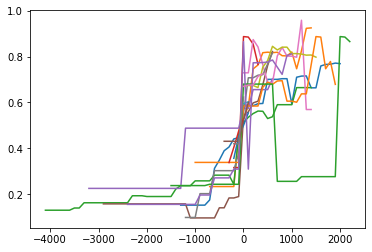

In [36]:
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"])
plt.show()

### Dan's Questions

Do large NGAs reach the SPC1 threshold again after a decline?

In [37]:
DF_Second = Cutout_DF.loc[Cutout_DF["RelTime"]>-1]
DF_Second.loc[DF_Second["SPC1"]< 0.49] # this is the SPC_Break from the other notebook

,NGA,RelTime,SPC1
261,Kachi Plain,700,0.255631
262,Kachi Plain,800,0.255631
263,Kachi Plain,900,0.255631
264,Kachi Plain,1000,0.255631
265,Kachi Plain,1100,0.255631
266,Kachi Plain,1200,0.276092
267,Kachi Plain,1300,0.276092
268,Kachi Plain,1400,0.276092
269,Kachi Plain,1500,0.276092
270,Kachi Plain,1600,0.276092


So indeed, the Orkhon Valley experiences a decline in SPC1 below the threshold after a discontinuous polity change!

In [38]:
# analyse this further
RelTimeDF.loc[RelTimeDF["NGA"] == "Orkhon Valley"]

,NGA,RelTime,SPC1
485,Orkhon Valley,-1900,0.315541
486,Orkhon Valley,-1800,0.315541
487,Orkhon Valley,-1700,0.315541
488,Orkhon Valley,-1600,0.315541
489,Orkhon Valley,-1500,0.315541
490,Orkhon Valley,-1400,0.315541
491,Orkhon Valley,-1300,0.315541
492,Orkhon Valley,-1200,0.315541
493,Orkhon Valley,-1100,0.315541
494,Orkhon Valley,-1000,0.315541


# Redo the RelTime Analysis with this Data?

## Fitting

In [39]:
X, y = Cutout_DF["RelTime"].to_numpy(), Cutout_DF["SPC1"].to_numpy()
T = 5000
X = np.array(list(X)) # for some reason, this transformation is necessary
X = X/T # normalisation of the data

def f(x, a, b, c, d):
    # the logistic function in its most general shape
    return a / (1. + np.exp(-c * (x - d))) + b

(a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, p0 = Parameters)

P0 = np.array((a_, b_, c_, d_))
print(P0)

[ 4.76748566e-01  2.11587418e-01  4.39930342e+01 -2.25088978e-02]


In [40]:
# comparison with full data:
Parameters

array([ 5.91641013e-01,  1.93784865e-01,  1.93749265e+01, -1.54321380e-02])

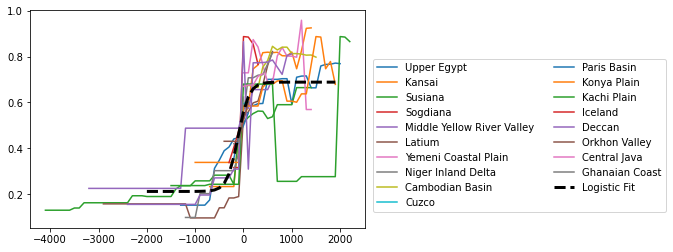

In [41]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"], label=n)

TimeRange = np.arange(-2000,2000,100)
New_Fit = f(TimeRange/T, a_, b_, c_, d_)
plt.plot(TimeRange, New_Fit, "--",label="Logistic Fit", c="k", linewidth = 3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.show()

## Out-of-Sample prediction
To evaluate quality of the fit.

In [42]:
L = len(Cutout_DF["RelTime"].to_numpy())
def RhoSq(y_hat, y_true): # like in Turchin's original PCA paper
    y_mean = np.mean(y_true)
    return(1 - sum((y_hat-y_true)**2)/sum((y_mean-y_true)**2)  )

In [43]:
C_list = list()
RhoSqList = list()
n_split = 1000
for i in range(1000):
    
    Selection = np.random.choice(np.arange(L), size = int(L/2), replace = False)
    
    X_train = X[Selection]
    y_train = y[Selection]
    
    test_indx = np.ones(len(X), bool)
    test_indx[Selection]=0
    y_test = y[test_indx]
    X_test = X[test_indx]
    
    (a1_, b1_, c1_, d1_), _ = opt.curve_fit(f, X_train, y_train,
                                            p0 = Parameters) # initial guess to ensure c > 0
    #print((a1_, b1_, c1_, d1_))
    C_list.append(c1_)
    RhoSqList.append(RhoSq( f(X_test, a1_, b1_, c1_, d1_), y_test))
    

C:\Users\Tobias\AppData\Local\Temp/ipykernel_16216/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [44]:
print(np.mean(RhoSqList), np.median(RhoSqList), np.std(RhoSqList))

0.7400531993921687 0.7428433505307115 0.032546559236915615


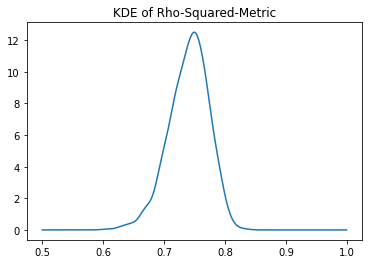

In [45]:
plt.plot(np.arange(0.5,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.5,1,0.001)))
plt.title("KDE of Rho-Squared-Metric")
plt.show()

## Bootstrapping

First round of bootstrap: estimate many parameter values for a and b and the standard deviations for a, b a+b. This allows to compute the thresholds of the plateaus.

In [46]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
negCcount = 0

Params = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters
NGA_list = list(set(Cutout_DF["NGA"]))


for i in range(nBT):
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection:
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0

    Params = pd.concat([Params,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_]})])
    if c_ < 0:
        print(NGA_selection)
        negCcount +=1
        for N in NGA_selection:
            DF = Data_RT[Data_RT["NGA"] == N]
            plt.plot(DF["RelTime"]/T,    # ALSO normalised
            DF["SPC1"], label=N)
            plt.plot(x_show, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # FOR FULL DATA
            plt.plot(x_show, f(x_show, a_, b_, c_, d_), "-.",c="r", linewidth = 3)

        plt.show()
        
    print(a_, b_, c_, d_)
    print("-----------------")
print(Params.round(2))

0.4639981671245345 0.2132335309662975 35.24931342995089 -0.027958913254240773
-----------------
0.5160770747918461 0.26990870825556845 24.18100714789163 -0.00893906129115229
-----------------
0.5331222336506507 0.17608480803675103 17.889933861961726 -0.0309806635363874
-----------------
0.5765139401623786 0.17236553121021245 29.95539830843246 -0.02603318716817576
-----------------
0.4720983565528894 0.20179074917568124 54.823352502969364 -0.020660187098223624
-----------------
0.4716478124649558 0.20104055311708618 46.76059662193238 -0.020604378642454076
-----------------
0.44913947543865257 0.20870542271800477 184.3010688838362 -0.01600091564669318
-----------------
0.46618177265758515 0.2020808350152631 51.881120496295324 -0.023562761950343906
-----------------
0.44930521594749007 0.23346167407751767 38.11997816514274 -0.02873091609534202
-----------------
0.47870653685458187 0.18686815056710088 53.456979927864715 -0.020883523337554027
-----------------
0.4870930435697615 0.211316642

0.5166138540133668 0.1763130205756453 56.60989413805424 -0.020840296579777547
-----------------
0.46496195955493197 0.22196349916382735 44.28005751359659 -0.024928685145415123
-----------------
0.4033221334567706 0.2388761894604995 78.1446803794165 -0.020479026276295446
-----------------
0.4185565730510718 0.24138588715496673 100.47214440631979 -0.01618891807089637
-----------------
0.4908929661458539 0.2077894678255092 34.52211105798094 -0.028097017415421643
-----------------
0.5405037290187671 0.19429642890657925 16.79744329407944 -0.03109485768966187
-----------------
0.4568470392608204 0.19432789116841417 34.3046726117548 -0.03336172916271473
-----------------
0.5297413400438945 0.21561453000131506 16.4191038977668 -0.025896795522932232
-----------------
0.5542899192175512 0.20234704460665834 34.113497365281766 -0.01721117438936821
-----------------
0.40861919095335664 0.26162381420705255 103.96603967548924 -0.015814006818014585
-----------------
0.5508985642186949 0.19025174737023

C:\Users\Tobias\AppData\Local\Temp/ipykernel_16216/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.4693681752755589 0.2117880662356291 34.506684906430145 -0.029928456400799903
-----------------
0.42720328278537845 0.18951048176379534 61.40627473127401 -0.02771053202353071
-----------------
0.5099570230119125 0.20890533975626782 59.78709596183879 -0.019907096487359215
-----------------
0.4948527692621844 0.19301995386590912 39.80411815281053 -0.019126841677742566
-----------------
0.461105748170745 0.19793896915740045 61.053352102564425 -0.022089466720981495
-----------------
0.4661227909387481 0.22978692969149933 61.56489888734422 -0.019724325181658512
-----------------
0.5300172746442835 0.19370033474884651 28.176641715285676 -0.031500523335763975
-----------------
0.5669414068195472 0.21921464286664552 14.668651738852255 -0.018691886983923753
-----------------
0.4600911183638581 0.18774681364829973 55.14823924083289 -0.023955268554480335
-----------------
0.4394825894728884 0.241765900561966 143.42492538980167 -0.015089987742376909
-----------------
0.5623095068029696 0.20103156

0.5627797893153721 0.1773614088218557 39.46218244990274 -0.018201743942016603
-----------------
0.505713695286778 0.20517915901515177 58.00625836247367 -0.017266428789125248
-----------------
0.48318366353737335 0.2182966869087975 96.9294168892361 -0.017906636437633825
-----------------
0.4902450931023638 0.18393837532658774 33.27302115865564 -0.02651424432285139
-----------------
0.47990728657882087 0.20914400006420952 38.0424821741645 -0.025114845072285414
-----------------
0.5306431974786923 0.19733704652894735 26.484939271056568 -0.021669839057519177
-----------------
0.5690051231525869 0.18777692112276126 13.523641869706347 -0.03311313898293485
-----------------
0.5253021840349863 0.23071315764358138 16.241368950787667 -0.02206347798050355
-----------------
0.3910477450412067 0.23453776506947224 51.1540731215764 -0.02840609629799225
-----------------
0.5500178670476938 0.21082939313662463 21.659287271001173 -0.015447942606653421
-----------------
0.4657961159460051 0.2400222737015

0.47283313668006083 0.2141617757757417 53.13111669407931 -0.020610368055188236
-----------------
0.43739681368149497 0.20966243057360381 103.28969550069627 -0.018739464581263302
-----------------
0.4674551642459507 0.22129852509498163 24.871724185712136 -0.025265454322876173
-----------------
0.5612852735334289 0.19205273967989533 21.87328273059839 -0.018789461509545347
-----------------
0.4560935474417607 0.23611117652493685 42.49553147321471 -0.02038094117709753
-----------------
0.5452494640574885 0.21003803701840554 21.650065942574667 -0.020122276347458046
-----------------
0.44722186607466496 0.19658419158067147 71.86302592180238 -0.02337761712027151
-----------------
0.3828588882675825 0.2468610770453637 64.35329587287156 -0.024451661410834376
-----------------
0.5463942088405505 0.2074555343291132 31.437546958565306 -0.016414255927271873
-----------------
0.5365020558487507 0.19135814656002254 22.61554553157637 -0.02563160037331862
-----------------
0.44187283039579817 0.2245282

0.5213135569983367 0.2070159108351243 27.472328156321407 -0.02318897102208864
-----------------
0.45974076828607363 0.23742907641223251 59.31514490737957 -0.01769216827483452
-----------------
0.5764012635727797 0.17548070054203269 22.135656523827066 -0.024497986014714777
-----------------
0.4558572419181134 0.21440092639141958 38.49427237710019 -0.024461658333482652
-----------------
0.41481893619635746 0.23751773847859772 49.40867361854901 -0.026132794699095716
-----------------
0.4535482747291364 0.21365921850990485 898.5624079937883 -0.018605719548994457
-----------------
0.46681867369178154 0.2338738224363269 48.21801531446233 -0.022477893681077218
-----------------
0.4919685919204484 0.21022371736956483 42.66363605532788 -0.020168261650280624
-----------------
0.5541404884142497 0.19889174876167054 19.780850211534464 -0.02175579549681306
-----------------
0.3897613184123015 0.2525561091573561 103.69551108565004 -0.018622484120894348
-----------------
0.5928380463357974 0.16892135

0.456343621752615 0.21535093993698487 23.771167667165336 -0.03209901695759728
-----------------
0.5500907749585072 0.18718279304294785 23.124734392685546 -0.025142061181846885
-----------------
0.5109115147675226 0.2523789639016329 32.62414085373355 -0.007263307478543138
-----------------
0.5298279334125009 0.21033990025908936 19.02855827152198 -0.03413524913550678
-----------------
0.5536775918996503 0.20032296166571076 24.694472615829266 -0.013752206387879702
-----------------
0.5327616930096426 0.19184975524366427 26.555469892091658 -0.02073850609835528
-----------------
0.45068665285483084 0.2376105287445525 22.487138632755386 -0.03677190634001553
-----------------
0.5021436615863706 0.2053722182496701 40.820334754374294 -0.018631119350176716
-----------------
0.5275567482016885 0.1776076911385926 47.31717920517863 -0.019764023888049924
-----------------
0.5464995097225508 0.18415437481284316 22.796642081978934 -0.019153544412216533
-----------------
0.5710360998893622 0.1973879076

0.5458795375061868 0.1846313875781263 32.21367243945106 -0.01994696897027406
-----------------
0.44232417813532 0.23484173775851577 57.13580106503803 -0.02079051511312486
-----------------
0.3982661338312332 0.22813151714457558 61.25952513481398 -0.024883346294696143
-----------------
0.473112334962789 0.19474942790281372 57.493441194061525 -0.02118161746080049
-----------------
0.5482830552989937 0.20028893668447775 23.792346479508897 -0.01696021202533303
-----------------
0.46997823094717933 0.18985418415555233 60.98889248424048 -0.023477327018486996
-----------------
0.48525396742523746 0.20584191458278464 55.852006436432234 -0.01640277117967239
-----------------
0.5162060597810871 0.19096878854539853 50.643967036345025 -0.021979338628651302
-----------------
0.3763153843947173 0.22915389715899592 847.6791671637923 -0.019371283102233953
-----------------
0.4027629271993413 0.23786270749649116 85.6297329324355 -0.018156843541185328
-----------------
0.49377721860821616 0.208537034295

0.4775656469616442 0.21297768686897564 35.98759129339321 -0.02258004393157377
-----------------
0.4923355354082112 0.21619951969110318 30.674116578859685 -0.029388257899154738
-----------------
0.4862040336028959 0.18849638547645212 64.17447478120108 -0.01808476511384523
-----------------
0.585235386009715 0.17825690922319937 27.882397739149418 -0.01725704343453932
-----------------
0.4829370547237436 0.2546872325240147 45.62695015749527 -0.01372120580829717
-----------------
0.4100528284864622 0.24413783115983115 84.48570780423803 -0.019029074769746374
-----------------
0.43484401472314366 0.2562087934905353 38.28376658708062 -0.02550598336577446
-----------------
0.3798617360204723 0.261600456618981 144.02105342397175 -0.015320397257383453
-----------------
0.37915734714811383 0.21949935409062382 69.70203243841866 -0.02865448558055597
-----------------
0.46742442603001233 0.21397687178381372 19.60374239471001 -0.04049119646845546
-----------------
0.41491012294267254 0.20648589093820

0.48957053223010066 0.21571452391205817 42.824411500442565 -0.024134193429713
-----------------
0.41213416406577724 0.24961515110016863 51.68752874790356 -0.024636750717897855
-----------------
0.41815101700106366 0.27846675704442164 80.44592149201887 -0.016684922585250207
-----------------
0.4063774175490418 0.22774137081241053 76.6958901317329 -0.02146079119355084
-----------------
0.4281441682820475 0.28092101939127373 56.39048648072773 -0.014234405904647801
-----------------
0.47018666356117705 0.20646893254212198 66.7029189785055 -0.017425009772524834
-----------------
0.4421253763544751 0.25236531081944846 108.34107185136874 -0.014312442710041715
-----------------
0.5327638567879425 0.2068476564638324 37.87646135730594 -0.020137503110946496
-----------------
0.5242046680339817 0.18425655994886941 20.46186873350032 -0.030635469541019134
-----------------
0.5559228401993103 0.22618935914424693 23.442263387235144 -0.01787028560645221
-----------------
0.4813939053422716 0.1800122307

0.5079364617994706 0.21474772023077052 32.3012603683714 -0.02088202287655051
-----------------
0.3635862255417812 0.30114290773841174 199.0195106879822 -0.01275068056016317
-----------------
0.4694124823015331 0.2222370676342194 36.21371405467198 -0.02187239602495138
-----------------
0.5158240872366783 0.22379520179321152 53.73259872296025 -0.01580696375358082
-----------------
0.5674376578854389 0.17170814124528666 45.85744071762525 -0.016324741447050043
-----------------
0.45948746219540676 0.19846044041329633 57.717771286175825 -0.02181780078892667
-----------------
0.4461053985747807 0.2170131626424523 24.99301101019184 -0.035674105066468835
-----------------
0.40650228012598044 0.28964884038620864 47.260451463779575 -0.016829036171248903
-----------------
0.5457123705851592 0.20242768131267655 46.643888910819086 -0.01315175238595126
-----------------
0.6177954125464836 0.15936339228807692 28.419998419842546 -0.016454561199180675
-----------------
0.5189667083198781 0.252616682053

0.35023588889479224 0.24835812058764623 887.7191652502479 -0.018992900283322407
-----------------
0.504770645091626 0.1785094034660499 65.68177917080558 -0.019372220795457307
-----------------
0.5360716174882886 0.18122535514844068 41.41900523360008 -0.023264852513344838
-----------------
0.41206877539333886 0.20278365861141875 92.07870538458452 -0.018612636112047068
-----------------
0.5136741572165554 0.22101720140311865 17.848786271312104 -0.024144031235228004
-----------------
0.49744538733767135 0.21806736000147114 34.95153946867103 -0.02471365315756503
-----------------
0.45904044321701404 0.2248418312174281 82.89149819684759 -0.019565300942913744
-----------------
0.501113386824399 0.2057822426628028 34.74568619470028 -0.021419049765576324
-----------------
0.4350065810552424 0.1963404153904947 47.80182291031478 -0.02533675554350971
-----------------
0.4496715165758526 0.20316378175380315 56.23307313045548 -0.023904009950329798
-----------------
0.3997650429005652 0.231325694375

In [47]:
print(negCcount)

0


In [48]:
Params

,a,b,c,d
0,0.463998,0.213234,35.249313,-0.027959
0,0.516077,0.269909,24.181007,-0.008939
0,0.533122,0.176085,17.889934,-0.030981
0,0.576514,0.172366,29.955398,-0.026033
0,0.472098,0.201791,54.823353,-0.020660
...,...,...,...,...
0,0.530047,0.233872,43.947047,-0.011642
0,0.398778,0.230033,704.408864,-0.018924
0,0.414698,0.227107,161.975086,-0.016226
0,0.508770,0.170739,44.617482,-0.028622


Mean 0.48993833631031475  and Median 0.48973195044222156
50% centred quantiles 0.446250102314514 0.5410399090788962
90% centred quantiles 0.3916949360732309 0.5798363772526175


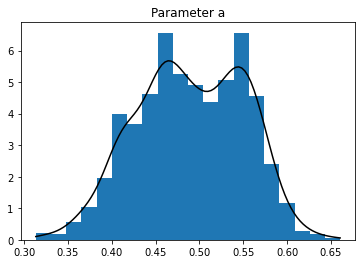

Mean 0.20826028008161315  and Median 0.20519084268866877
50% centred quantiles 0.1909725473023919 0.2237267401292618
90% centred quantiles 0.17291351860419188 0.25238782116441905


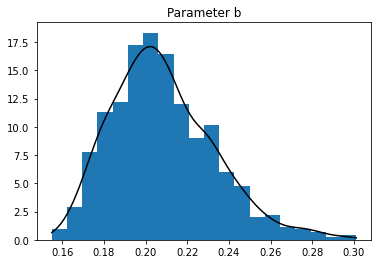

Mean 78.83299731974597  and Median 40.208745200924014
50% centred quantiles 28.126996058415774 61.00500738882147
90% centred quantiles 18.751259808187587 186.43019717584457


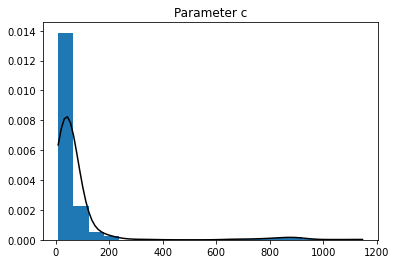

Mean -0.022100386356409693  and Median -0.02079414643701066
50% centred quantiles -0.025291857473397447 -0.01778778821264133
90% centred quantiles -0.03433499365654575 -0.013832633737654802


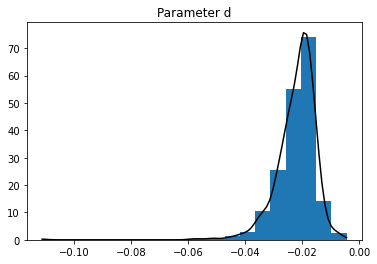

In [49]:
for P in Params.columns:
    
    
    Ps = Params[P]
    P_range = np.linspace(min(Ps), max(Ps),100)
    KDE = gaussian_kde(Ps)(P_range)
    print("Mean", np.mean(Ps), " and Median", np.median(Ps))
    print("50% centred quantiles", np.quantile(Ps, 0.25), 
          np.quantile(Ps, 0.75))
    print("90% centred quantiles", np.quantile(Ps, 0.05), 
          np.quantile(Ps, 0.95))
    plt.hist(Ps,bins=20, density= True)
    plt.plot(P_range, KDE, c="k")
    plt.title("Parameter "+str(P))
    plt.show()

### In more detail for c

In [50]:
np.quantile(Params["c"], 0.25), np.quantile(Params["c"], 0.75)

(28.126996058415774, 61.00500738882147)

[1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.16227766e+04 3.98107171e+04 5.01187234e+04
 6.30957344e+04 7.94328235e+04]


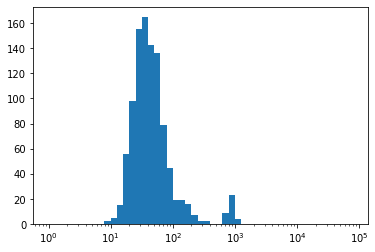

In [51]:
bins = 10**(np.arange(0,5,0.1))
print(bins)
plt.xscale('log')
plt.hist(Params["c"],bins=bins) 


plt.show()

### Analysis of the Curve

When does f(x) = y_est actually change? 
f(-infinity) = b and f(infinity) = a + b. We can now calculate the standard deviations of b and a+b via the bootstrap estimations and check when y_est exceeds b + sd(b) and reaches a+b - sd(a+b).

In [52]:
print(np.mean(Params["b"]), np.std(Params["b"]))
print(np.mean(Params["b"]+Params["a"]), np.std(Params["b"]+Params["a"]))

Thresh1 = np.mean(Params["b"]) + np.std(Params["b"])
Thresh2 = np.mean(Params["b"]+Params["a"]) - np.std(Params["b"]+Params["a"])
print(Thresh1, Thresh2)

def f1(x):
    # first threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh1)

T1 = opt.root(f1, -0.5)

def f2(x):
    # second threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh2)

T2 = opt.root(f2, 0.5)

0.20826028008161315 0.024646956393918354
0.698198616391928 0.04766320502910415
0.23290723647553152 0.6505354113628239


C:\Users\Tobias\AppData\Local\Temp/ipykernel_16216/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [53]:
Timeframe = (T2["x"] -T1["x"])[0]
t_2, t_1 = T2["x"], T1["x"]
# scale this back to original time
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*Timeframe), "years.")

Most of the cultural evolution takes place in a time interval of  627.0 years.


## Bootstrapping the Time Interval

Now we can repeat this task, but 

-> Calculate the time thresholds T1/T2 for every single Bootstrapped Data and therefore calculate a time interval with standard deviation

In [54]:
def fBT1(x):
    # first threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh1)

def fBT2(x):
    # second threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh2)


In [55]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
Successes = 0

Params2 = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters

for i in range(nBT):
    
    # Select the random NGAs
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection: # combine them to a data frame
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0
    
    # Time Intervals
    T1 = opt.root(fBT1, t_1)
    T2 = opt.root(fBT2, t_2)
    
    # only add results, if opt.root is successful:
    if T1["success"] and T2["success"]:
        Successes += 1
        Params2 = pd.concat([Params2,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_], "T1":T1["x"], "T2":T2["x"]})])    
        print(a_, b_, c_, d_, T1, T2)
        print("-----------------")


0.4639981671245345 0.2132335309662975 35.24931342995089 -0.027958913254240773     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-3.05191983e-12])
       r: array([-0.66408095])
  status: 1
 success: True
       x: array([-0.11639389])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.08801856e-14])
       r: array([-0.88688356])
  status: 1
 success: True
       x: array([0.0513646])
-----------------
0.5331222336506507 0.17608480803675103 17.889933861961726 -0.0309806635363874     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-3.5244585e-12])
       r: array([-0.90820159])
  status: 1
 success: True
       x: array([-0.14982495])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([7.09432513e-13])
       r: array([-0.93411672])
  status: 1
 

C:\Users\Tobias\AppData\Local\Temp/ipykernel_16216/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.4941084967212582 0.22195248286075597 56.969781195550425 -0.01930692140997849     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.68609049e-12])
       r: array([-0.61025414])
  status: 1
 success: True
       x: array([-0.08577306])     fjac: array([[-1.]])
     fun: array([7.77156117e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.40223064e-10])
       r: array([-3.23794429])
  status: 1
 success: True
       x: array([0.01365869])
-----------------
0.4631280886745812 0.20289370988572877 37.09084715006148 -0.026867914468340248     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-9.99200722e-15])
       r: array([-1.04108323])
  status: 1
 success: True
       x: array([-0.09883591])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([5.10702591e-15])
       r: array([-0.555195

0.5163683344595789 0.1940157108762861 43.71554820776547 -0.016385445888418906     fjac: array([[-1.]])
     fun: array([9.43689571e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.01336559e-10])
       r: array([-1.57210519])
  status: 1
 success: True
       x: array([-0.07375037])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.02617914e-11])
       r: array([-2.31307594])
  status: 1
 success: True
       x: array([0.0300926])
-----------------
0.5798267110478492 0.1743735545296484 41.22090162751873 -0.01903903363449179     fjac: array([[-1.]])
     fun: array([6.38378239e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.90011284e-10])
       r: array([-2.16922986])
  status: 1
 success: True
       x: array([-0.07208761])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.3211654e-14])
       r: array([-3.50

0.5274960039417929 0.1936082126253415 24.824444089836277 -0.02489816442459835     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-8.97892871e-13])
       r: array([-0.90289506])
  status: 1
 success: True
       x: array([-0.12639165])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.34403599e-12])
       r: array([-1.51747028])
  status: 1
 success: True
       x: array([0.05034766])
-----------------
0.5740672439347453 0.17430892838074674 33.33487307301283 -0.017153751632076174     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([8.22064639e-13])
       r: array([-1.75397609])
  status: 1
 success: True
       x: array([-0.08238188])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.23741034e-13])
       r: array([-2.70563614]

0.5886956048244171 0.16599405976906842 26.554261341173028 -0.018500168058154524     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-6.10539397e-13])
       r: array([-1.57486946])
  status: 1
 success: True
       x: array([-0.09584575])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.1449286e-11])
       r: array([-2.27641496])
  status: 1
 success: True
       x: array([0.03939373])
-----------------
0.5512115250128645 0.18361483065979486 32.52707785275727 -0.0201525880555645     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([3.79027365e-12])
       r: array([-1.45995774])
  status: 1
 success: True
       x: array([-0.09149834])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-9.31354993e-12])
       r: array([-2.32247168])
  status: 1

0.5839838898433651 0.17735444171872028 27.916265610014797 -0.02230582527302948     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-7.88535903e-14])
       r: array([-1.40330071])
  status: 1
 success: True
       x: array([-0.10299637])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.72670775e-13])
       r: array([-2.50631075])
  status: 1
 success: True
       x: array([0.029697])
-----------------
0.48219168657733524 0.2315494649351433 49.60299360276628 -0.01680478329105736     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-6.66341982e-12])
       r: array([-0.06716021])
  status: 1
 success: True
       x: array([-0.13513791])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.1649349e-14])
       r: array([

0.45230368052071823 0.20611025885625536 79.23804530830611 -0.019252848712146137     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([1.24678046e-13])
       r: array([-1.99754156])
  status: 1
 success: True
       x: array([-0.0541476])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.52740059e-12])
       r: array([-0.61340448])
  status: 1
 success: True
       x: array([0.03163988])
-----------------
0.5540809797923959 0.1740371610788941 27.924797011025575 -0.018313831122654424     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-3.58046925e-14])
       r: array([-1.46926989])
  status: 1
 success: True
       x: array([-0.09457762])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.79332113e-13])
       r: array([-1.86313003])
  status:

       x: array([0.03623476])
-----------------
0.5597097852676883 0.19281751378017656 20.230421821418286 -0.01860581853816622     fjac: array([[-1.]])
     fun: array([8.32667268e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-4.5891374e-11])
       r: array([-0.75294246])
  status: 1
 success: True
       x: array([-0.14524568])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.37569989e-13])
       r: array([-1.68735162])
  status: 1
 success: True
       x: array([0.05560716])
-----------------
0.5731555864430626 0.19205592646565528 28.613730332910436 -0.016975593159872966     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.58120217e-12])
       r: array([-1.08559572])
  status: 1
 success: True
       x: array([-0.10669743])     fjac: array([[-1.]])
     fun: array([-9.99200722e-16])
 message: 'The solution converged.'
    nfev: 6
 

       x: array([-0.06070706])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([7.35522754e-13])
       r: array([-0.25049911])
  status: 1
 success: True
       x: array([0.04297096])
-----------------
0.56844887124714 0.17915804955518738 22.574659544892732 -0.01883140646567339     fjac: array([[-1.]])
     fun: array([1.05471187e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-2.36217879e-10])
       r: array([-1.09864532])
  status: 1
 success: True
       x: array([-0.11891066])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.40474307e-13])
       r: array([-1.81714808])
  status: 1
 success: True
       x: array([0.05116792])
-----------------
0.4995018951172155 0.20439262164084798 28.390066057443125 -0.024358628824666977     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array(

0.4710544979947307 0.21084518775077668 19.1883297895832 -0.04269095948571761     fjac: array([[-1.]])
     fun: array([7.99360578e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-5.96229038e-10])
       r: array([-0.40351224])
  status: 1
 success: True
       x: array([-0.19972116])     fjac: array([[-1.]])
     fun: array([-1.11022302e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.0967228e-10])
       r: array([-0.5617595])
  status: 1
 success: True
       x: array([0.09491356])
-----------------
0.5689869919652583 0.22830481714399842 35.40755425441206 -0.0123706952580901     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-9.38582545e-13])
       r: array([-0.16164237])
  status: 1
 success: True
       x: array([-0.14819351])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.81943349e-11])
       r: array([-

0.540520314041996 0.19911990046681133 20.941400680761145 -0.02959645421195822     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-8.63475957e-14])
       r: array([-0.66332574])
  status: 1
 success: True
       x: array([-0.15890481])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.11022302e-14])
       r: array([-1.55837261])
  status: 1
 success: True
       x: array([0.04788523])
-----------------
0.513363104289616 0.1804071411100762 36.4106514607563 -0.021709983724600788     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([9.75658443e-12])
       r: array([-1.716074])
  status: 1
 success: True
       x: array([-0.08137071])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.53066448e-12])
       r: array([-1.44163082])
  status: 1
 su

0.4902450931023638 0.18393837532658774 33.27302115865564 -0.02651424432285139     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-1.235817e-12])
       r: array([-1.4665931])
  status: 1
 success: True
       x: array([-0.09258839])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([3.19334559e-11])
       r: array([-0.74888875])
  status: 1
 success: True
       x: array([0.06311348])
-----------------
0.47990728657882087 0.20914400006420952 38.0424821741645 -0.025114845072285414     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-4.60301242e-12])
       r: array([-0.85924971])
  status: 1
 success: True
       x: array([-0.10278246])     fjac: array([[-1.]])
     fun: array([-1.55431223e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.03535197e-10])
       r: array([-

0.43176369012796656 0.22815222116979758 141.04597371818699 -0.01575214046217291     fjac: array([[-1.]])
     fun: array([-3.5249581e-15])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.93840333e-10])
       r: array([-0.66330165])
  status: 1
 success: True
       x: array([-0.04763965])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-1.32338585e-13])
       r: array([-1.29433662])
  status: 1
 success: True
       x: array([0.01124104])
-----------------
0.5599212553369002 0.19252457394928313 30.16293573579961 -0.014339276403546852     fjac: array([[-1.]])
     fun: array([1.19348975e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-2.55700738e-10])
       r: array([-1.13021595])
  status: 1
 success: True
       x: array([-0.09903065])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.0880

0.5165929217677793 0.20089204435705907 35.652236693270396 -0.021853166330136134     fjac: array([[-1.]])
     fun: array([1.55431223e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-2.76976053e-10])
       r: array([-1.07068165])
  status: 1
 success: True
       x: array([-0.09806346])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([9.54791801e-15])
       r: array([-2.07756333])
  status: 1
 success: True
       x: array([0.03156607])
-----------------
0.5284593829039917 0.21156579860533745 19.09875273601953 -0.025480669231254263     fjac: array([[-1.]])
     fun: array([2.72004641e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.01436515e-10])
       r: array([-0.39113795])
  status: 1
 success: True
       x: array([-0.19136024])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.23523414e-12])
       r: arra

       x: array([-0.07061528])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.26514379e-12])
       r: array([-2.7582402])
  status: 1
 success: True
       x: array([0.02999696])
-----------------
0.4536598120305331 0.21471241281756903 15.601940730206756 -0.045579557150320096     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.49746882e-12])
       r: array([-0.27248937])
  status: 1
 success: True
       x: array([-0.24909765])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([7.99360578e-15])
       r: array([-0.26734728])
  status: 1
 success: True
       x: array([0.15926494])
-----------------
0.554270690195995 0.20556932998357597 50.86306756379884 -0.017686317361367866     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: arr

0.5365020558487507 0.19135814656002254 22.61554553157637 -0.02563160037331862     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-7.13856751e-12])
       r: array([-0.86688476])
  status: 1
 success: True
       x: array([-0.13518399])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.91224814e-12])
       r: array([-1.49670044])
  status: 1
 success: True
       x: array([0.05313819])
-----------------
0.44187283039579817 0.22452821572617815 40.3776284610193 -0.024080557005250275     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-4.25492974e-14])
       r: array([-0.33190952])
  status: 1
 success: True
       x: array([-0.12181157])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([3.16370263e-11])
       r: array([-0.6176167

       x: array([-0.0978813])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([9.33697564e-14])
       r: array([-1.39421175])
  status: 1
 success: True
       x: array([0.04133728])
-----------------
0.57565302617048 0.1753792311301366 32.78035232151038 -0.011921316639223618     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.39624448e-11])
       r: array([-1.69733417])
  status: 1
 success: True
       x: array([-0.07897199])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.34257058e-14])
       r: array([-2.71920304])
  status: 1
 success: True
       x: array([0.0354704])
-----------------
0.5396629741462814 0.1809228621783868 28.977295161415164 -0.028265448894065383     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qt

0.48682947179982256 0.20768856371678474 42.03313967092574 -0.014988932480232111     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.17553753e-12])
       r: array([-1.00510939])
  status: 1
 success: True
       x: array([-0.08415192])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.99760217e-14])
       r: array([-1.68170451])
  status: 1
 success: True
       x: array([0.03995413])
-----------------
0.547117316280106 0.1792679671762895 24.587727319468808 -0.028325036541264594     fjac: array([[-1.]])
     fun: array([3.05311332e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-4.63206723e-10])
       r: array([-1.18957411])
  status: 1
 success: True
       x: array([-0.11858132])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.33066907e-14])
       r: array(

0.44306634243875653 0.224206512527756 30.831404347653827 -0.03589447720354454     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-3.31787375e-12])
       r: array([-0.26298792])
  status: 1
 success: True
       x: array([-0.1627288])     fjac: array([[-1.]])
     fun: array([-1.88737914e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.26580421e-10])
       r: array([-0.49654906])
  status: 1
 success: True
       x: array([0.06911413])
-----------------
0.5984054674750711 0.1549095738991558 30.798053045862083 -0.018406397702888773     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.12377901e-12])
       r: array([-2.08907101])
  status: 1
 success: True
       x: array([-0.08003152])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-1.44206869e-12])
       r: array([-2.62173397

       x: array([0.01370052])
-----------------
0.49475859735761024 0.19845798538489837 38.327854364348624 -0.01879417510120174     fjac: array([[-1.]])
     fun: array([-5.27355937e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-6.02557948e-10])
       r: array([-1.22842016])
  status: 1
 success: True
       x: array([-0.08643197])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.54396545e-13])
       r: array([-1.49475624])
  status: 1
 success: True
       x: array([0.04278234])
-----------------
0.541488446023276 0.2086041351310858 24.330403517722946 -0.016306698043742872     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.44051437e-14])
       r: array([-0.56476532])
  status: 1
 success: True
       x: array([-0.14198473])     fjac: array([[-1.]])
     fun: array([-2.33146835e-15])
 message: 'The solution converged.

0.45928358886830173 0.20174921101215018 46.62055487332977 -0.023773956452195946     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([7.19702076e-14])
       r: array([-1.35405898])
  status: 1
 success: True
       x: array([-0.07997974])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([3.77475828e-15])
       r: array([-0.47820866])
  status: 1
 success: True
       x: array([0.05677893])
-----------------
0.5409743161211966 0.19948608740084586 19.516395155365228 -0.02895387178024681     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.46389584e-13])
       r: array([-0.61196407])
  status: 1
 success: True
       x: array([-0.16834501])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.2759572e-13])
       r: array([-1.46327995])
  status

0.4570998632049704 0.2132093635611875 49.180972063864594 -0.028563627254638537     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([7.45467577e-12])
       r: array([-0.92701227])
  status: 1
 success: True
       x: array([-0.09160309])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([8.43769499e-15])
       r: array([-0.93042595])
  status: 1
 success: True
       x: array([0.03439406])
-----------------
0.5445747701876238 0.18599249117888952 23.74939902338028 -0.027110092566418106     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.75196532e-13])
       r: array([-1.01820976])
  status: 1
 success: True
       x: array([-0.12654777])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.08562073e-14])
       r: array([-1.62137624]

       x: array([0.06353154])
-----------------
0.5524932600664668 0.1703069428228135 53.51018119606795 -0.016553222889368946     fjac: array([[-1.]])
     fun: array([-1.3017365e-14])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.18437232e-09])
       r: array([-2.97017636])
  status: 1
 success: True
       x: array([-0.0550023])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.18292043e-11])
       r: array([-3.36111886])
  status: 1
 success: True
       x: array([0.01884051])
-----------------
0.5898057499270728 0.17258277514845094 25.429985418325078 -0.01925330158178938     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.22846178e-13])
       r: array([-1.37714983])
  status: 1
 success: True
       x: array([-0.10467058])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'


0.5205905916751012 0.1905363051595353 59.23698216031316 -0.018904302505677237     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([4.42701431e-14])
       r: array([-2.30564283])
  status: 1
 success: True
       x: array([-0.05981806])     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.25491617e-10])
       r: array([-3.17151122])
  status: 1
 success: True
       x: array([0.01531537])
-----------------
0.5151365981999099 0.19493370432131754 32.42601256051945 -0.02564670874290175     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.38392076e-12])
       r: array([-1.14056242])
  status: 1
 success: True
       x: array([-0.10370037])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.31223937e-12])
       r: array(

0.5336428807841319 0.19492508121688104 18.86001368632961 -0.02475092629821954     fjac: array([[-1.]])
     fun: array([7.18869408e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-7.08421211e-10])
       r: array([-0.66536479])
  status: 1
 success: True
       x: array([-0.16095312])     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.38140943e-10])
       r: array([-1.25649767])
  status: 1
 success: True
       x: array([0.06880743])
-----------------
0.6425173886919867 0.1802022692285501 24.585428863584585 -0.006215431387585479     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.11743947e-13])
       r: array([-1.18948339])
  status: 1
 success: True
       x: array([-0.1044482])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([1.83355553e-11])
       r: array([

0.5803241869404567 0.19167365250587315 11.968015875463218 -0.02622085700283236     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-4.22387125e-12])
       r: array([-0.45842101])
  status: 1
 success: True
       x: array([-0.24101257])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.50817161e-12])
       r: array([-1.14941113])
  status: 1
 success: True
       x: array([0.08483715])
-----------------
0.5458795375061868 0.1846313875781263 32.21367243945106 -0.01994696897027406     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-5.55666624e-14])
       r: array([-1.4176106])
  status: 1
 success: True
       x: array([-0.09236568])     fjac: array([[-1.]])
     fun: array([-1.44328993e-15])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([2.92172952e-10])
       r: array([-2.19886791]

0.5076477970913539 0.2043245827312832 48.291412646060756 -0.024095050459934323     fjac: array([[-1.]])
     fun: array([-1.33226763e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.11259593e-10])
       r: array([-1.30258848])
  status: 1
 success: True
       x: array([-0.08247058])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.54718469e-11])
       r: array([-2.60781565])
  status: 1
 success: True
       x: array([0.01696359])
-----------------
0.5299022136065756 0.20310249747977874 33.94417762350944 -0.01768406824320611     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-9.52571355e-14])
       r: array([-0.95479375])
  status: 1
 success: True
       x: array([-0.10076564])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-7.18117787e-11])
       r: arra

0.44667597765502737 0.22450386729606694 51.958557485338865 -0.019440498111327167     fjac: array([[-1.]])
     fun: array([1.66533454e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-3.99566491e-11])
       r: array([-0.42841435])
  status: 1
 success: True
       x: array([-0.09554362])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.62723218e-14])
       r: array([-1.02307915])
  status: 1
 success: True
       x: array([0.03881877])
-----------------
0.4371955533076534 0.2325464930777583 34.52248354928741 -0.02496671019760177     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-1.47437618e-13])
       r: array([-0.01244349])
  status: 1
 success: True
       x: array([-0.23060497])     fjac: array([[-1.]])
     fun: array([-5.55111512e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.09477316e-10])
       r: arra

0.5499250201819791 0.21287421485671973 32.505711214878104 -0.021366218619967816     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-3.86096155e-11])
       r: array([-0.62746734])
  status: 1
 success: True
       x: array([-0.1221267])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.64679381e-12])
       r: array([-2.9042508])
  status: 1
 success: True
       x: array([0.02049084])
-----------------
0.4913176453827884 0.20008062453111236 53.014625238814176 -0.019939142344370452     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.67477152e-11])
       r: array([-1.62401309])
  status: 1
 success: True
       x: array([-0.0696745])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.3999914e-11])
       r: arra

0.5085835771116622 0.17628753163707714 33.989625023260125 -0.02565015275298105     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.06838927e-10])
       r: array([-1.71022972])
  status: 1
 success: True
       x: array([-0.08676425])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([5.21804822e-15])
       r: array([-1.08826685])
  status: 1
 success: True
       x: array([0.05159532])
-----------------
0.5736914215998741 0.18321768996154464 35.502759066331855 -0.01087762415901166     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.07136522e-14])
       r: array([-1.61131931])
  status: 1
 success: True
       x: array([-0.07723023])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([9.30366895e-14])
       r: array

0.481689976607367 0.19883001295003144 39.0303437478894 -0.024035783598572526     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.84546822e-13])
       r: array([-1.23595141])
  status: 1
 success: True
       x: array([-0.09001776])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.614442e-11])
       r: array([-1.09746004])
  status: 1
 success: True
       x: array([0.04545751])
-----------------
0.562041343857609 0.18477396957291123 43.968100067313706 -0.017654440200954358     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-5.05429032e-14])
       r: array([-1.93508571])
  status: 1
 success: True
       x: array([-0.07151328])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-5.6510352e-14])
       r: array([-

       x: array([0.07549336])
-----------------
0.5364866979578596 0.19437392337824155 19.109242756449074 -0.02405846158348713     fjac: array([[-1.]])
     fun: array([3.35842465e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-4.44987103e-10])
       r: array([-0.68345959])
  status: 1
 success: True
       x: array([-0.15797184])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.72408804e-11])
       r: array([-1.30513584])
  status: 1
 success: True
       x: array([0.06682758])
-----------------
0.5551966688042621 0.1780812307397356 34.84945698291065 -0.02038671048451698     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.68587366e-13])
       r: array([-1.72197813])
  status: 1
 success: True
       x: array([-0.08383632])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([

       x: array([0.0314879])
-----------------
0.4879597802874423 0.18120711745477244 51.72188705200465 -0.02403282101395577     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([2.66453526e-14])
       r: array([-2.39071023])
  status: 1
 success: True
       x: array([-0.06526831])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.77555756e-14])
       r: array([-0.926861])
  status: 1
 success: True
       x: array([0.03834792])
-----------------
0.49218996954015787 0.17382579494747774 47.84496298475158 -0.01864534853951492     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.03575482e-12])
       r: array([-2.48743269])
  status: 1
 success: True
       x: array([-0.06028132])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([

0.48957053223010066 0.21571452391205817 42.824411500442565 -0.024134193429713     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-4.57581195e-12])
       r: array([-0.71041216])
  status: 1
 success: True
       x: array([-0.10150347])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-6.11832807e-12])
       r: array([-2.08241861])
  status: 1
 success: True
       x: array([0.02425324])
-----------------
0.47018666356117705 0.20646893254212198 66.7029189785055 -0.017425009772524834     fjac: array([[-1.]])
     fun: array([-7.82707232e-15])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-6.08773809e-10])
       r: array([-1.66432949])
  status: 1
 success: True
       x: array([-0.05970867])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-4.54081217e-14])
       r: arr

0.5061267065342795 0.18338124577879125 48.78311567147612 -0.016882335120090904     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([8.80351347e-13])
       r: array([-2.17961655])
  status: 1
 success: True
       x: array([-0.06241677])     fjac: array([[-1.]])
     fun: array([-4.4408921e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([1.03051234e-10])
       r: array([-1.75481432])
  status: 1
 success: True
       x: array([0.03403286])
-----------------
0.4803608662847041 0.20287317917087241 26.90524885596688 -0.03435551330868738     fjac: array([[-1.]])
     fun: array([8.8817842e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.77761694e-10])
       r: array([-0.75755364])
  status: 1
 success: True
       x: array([-0.1349917])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([3.68483022e-13])
       r: array([-0

       x: array([0.03250673])
-----------------
0.5438332544935127 0.20027977339046565 29.367539737653214 -0.0238540294045091     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.8562929e-13])
       r: array([-0.90070154])
  status: 1
 success: True
       x: array([-0.11754992])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([5.90860694e-13])
       r: array([-2.27526988])
  status: 1
 success: True
       x: array([0.02964123])
-----------------
0.5474582606192393 0.1657017547791642 34.62833902136195 -0.022952306604104408     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.42622589e-11])
       r: array([-2.04152937])
  status: 1
 success: True
       x: array([-0.07974272])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
    

       x: array([0.01645725])
-----------------
0.4577625004042117 0.19681105331158735 51.81996199000405 -0.02781786997401474     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.57929225e-14])
       r: array([-1.72300706])
  status: 1
 success: True
       x: array([-0.07525185])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([2.87757596e-11])
       r: array([-0.20741168])
  status: 1
 success: True
       x: array([0.06329962])
-----------------
0.46649068199584465 0.19000401773228148 55.32211075833584 -0.02315070664315977     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([7.99074695e-12])
       r: array([-2.15520699])
  status: 1
 success: True
       x: array([-0.06454127])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10

0.46643980534212165 0.23174798676590147 34.54752894449663 -0.021815088179681384     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-6.04616357e-12])
       r: array([-0.03994988])
  status: 1
 success: True
       x: array([-0.19534031])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.36557432e-14])
       r: array([-1.47808576])
  status: 1
 success: True
       x: array([0.04109624])
-----------------
0.5348197014187394 0.17636162714381218 29.878951173183694 -0.024779680642673448     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-3.29905547e-12])
       r: array([-1.51089332])
  status: 1
 success: True
       x: array([-0.09623923])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([9.68114477e-14])
       r: arr

       x: array([0.04695757])
-----------------
0.4293204093710524 0.2310436999349747 173.84979559763724 -0.015136346332671444     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([5.19029264e-15])
       r: array([-0.32256922])
  status: 1
 success: True
       x: array([-0.04640114])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.33146835e-15])
       r: array([-1.66959714])
  status: 1
 success: True
       x: array([0.0064555])
-----------------
0.5217417058847796 0.18943856338805296 25.54132414827971 -0.0198247059087215     fjac: array([[-1.]])
     fun: array([3.05311332e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.01113951e-10])
       r: array([-1.01775076])
  status: 1
 success: True
       x: array([-0.1137173])     fjac: array([[-1.]])
     fun: array([-2.10942375e-15])
 message: 'The solution converged.'
    nfev: 8
   

0.5082376919796104 0.18891526283835147 47.50398421627415 -0.01957926742435189     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.51545443e-14])
       r: array([-1.90890588])
  status: 1
 success: True
       x: array([-0.06918367])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.55271368e-15])
       r: array([-2.01139506])
  status: 1
 success: True
       x: array([0.02868543])
-----------------
0.528107778781802 0.2328400590615695 25.826657796650867 -0.017105875686297085     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-1.44717571e-13])
       r: array([-0.00173475])
  status: 1
 success: True
       x: array([-0.36440561])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([1.59586788e-11])
       r: array([-2.2553998])
  status: 

       x: array([0.01214459])
-----------------
0.5021321908635757 0.21310702637973172 42.92385425657443 -0.019450515502368596     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-7.08877401e-14])
       r: array([-0.81638784])
  status: 1
 success: True
       x: array([-0.09383666])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.17916787e-12])
       r: array([-2.41945473])
  status: 1
 success: True
       x: array([0.02507235])
-----------------
0.46858992140165473 0.20897582834207956 48.865726711877016 -0.025231092878988406     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.33563732e-12])
       r: array([-1.10970239])
  status: 1
 success: True
       x: array([-0.08502996])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.39808

0.4588419629981691 0.22525627297647668 48.58669428667417 -0.02106670810765523     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.66811009e-14])
       r: array([-0.36553652])
  status: 1
 success: True
       x: array([-0.10497979])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([8.4143803e-13])
       r: array([-1.51142548])
  status: 1
 success: True
       x: array([0.03119712])
-----------------
0.5323337523710934 0.19208404877155394 24.945296625105836 -0.020100491391028538     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.38420395e-14])
       r: array([-0.94025237])
  status: 1
 success: True
       x: array([-0.11984808])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([6.59128307e-12])
       r: array([-1.58722698])
  status: 

In [56]:
print(Successes)
print(Params2.round(2))

720
       a     b      c     d    T1    T2
0   0.46  0.21  35.25 -0.03 -0.12  0.05
0   0.53  0.18  17.89 -0.03 -0.15  0.09
0   0.58  0.17  29.96 -0.03 -0.10  0.03
0   0.47  0.20  54.82 -0.02 -0.07  0.03
0   0.47  0.20  46.76 -0.02 -0.08  0.04
..   ...   ...    ...   ...   ...   ...
0   0.50  0.18  92.52 -0.02 -0.04  0.01
0   0.46  0.19  49.46 -0.02 -0.06  0.14
0   0.56  0.20  33.01 -0.02 -0.10  0.03
0   0.51  0.17  44.62 -0.03 -0.07  0.03
0   0.48  0.22  20.90 -0.04 -0.21  0.07

[720 rows x 6 columns]


In [57]:
T2_scaled, T1_scaled = np.mean(Params2["T2"])*T, T*np.mean(Params2["T1"])

T1_start_scaled = T*np.mean(Params2["T1"]) - T*np.std(Params2["T1"])
T2_end_scaled = T*np.mean(Params2["T2"]) + T*np.std(Params2["T2"])

In [58]:
TimeframeBT = Params2["T2"]-Params2["T1"]
print(np.mean(TimeframeBT))

# times T for the transformation to years
#print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)),
 #     u"\u00B1",np.round(T*np.std(TimeframeBT)), "years.")

0.1544732182167217


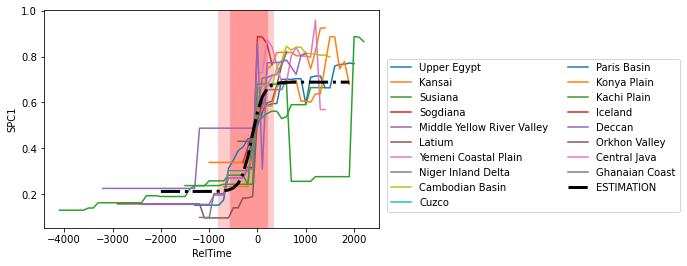

In [59]:
DF_Out_cutout = pd.DataFrame(columns=["NGA","RelTime","SPC1"])

for N in list(set(Cutout_DF["NGA"])):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    #print(N)
    
plt.plot(TimeRange, New_Fit, "-.",label="ESTIMATION", c = "k", linewidth=3)

plt.ylabel("SPC1")
plt.xlabel("RelTime")
plt.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
plt.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
plt.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)

plt.savefig("SPC1_Time_Interval_Cutouts_Bootstrapped_no_Legend.pdf",dpi = 200, bbox_inches='tight')
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.savefig("SPC1_Time_Interval_Cutouts_Bootstrapped",dpi = 200, bbox_inches='tight')
plt.savefig("SPC1_Time_Interval_Cutouts_Bootstrapped.pdf",dpi = 200, bbox_inches='tight')
plt.show()

In [60]:
Cutout_CCDF.index = np.arange(0,len(Cutout_CCDF["NGA"]))
Cutout_CCDF.to_csv("Cutouts_CC_with_Reltime.csv")

In [61]:
Cutout_DF[Cutout_DF["NGA"] == "Yemeni Coastal Plain"]


,NGA,RelTime,SPC1
413,Yemeni Coastal Plain,0,0.729010
414,Yemeni Coastal Plain,100,0.729010
415,Yemeni Coastal Plain,200,0.874002
416,Yemeni Coastal Plain,300,0.841906
417,Yemeni Coastal Plain,500,0.686559
418,Yemeni Coastal Plain,600,0.686559
419,Yemeni Coastal Plain,700,0.802861
420,Yemeni Coastal Plain,800,0.839822
421,Yemeni Coastal Plain,900,0.801720
422,Yemeni Coastal Plain,1000,0.801720


Cambodian Basin
166       0
167     100
168     200
169     300
170     400
171     500
172     600
173     700
174     800
175     900
176    1000
177    1100
178    1200
179    1300
180    1400
181    1500
Name: RelTime, dtype: object
Central Java
519      0
520    100
521    200
522    300
523    400
Name: RelTime, dtype: object
Cuzco
483      0
484    100
Name: RelTime, dtype: object
Deccan
427    -2400
428    -2300
429    -2200
430    -2100
431    -2000
432    -1900
433    -1800
434    -1700
435    -1600
436    -1500
437    -1400
438    -1300
439    -1200
440    -1100
441    -1000
442     -900
443     -800
444     -700
445     -600
446     -500
447     -400
448     -300
449     -200
450     -100
451        0
452      100
453      200
454      300
455      400
456      500
457      600
458      800
459      900
460     1000
Name: RelTime, dtype: object
Ghanaian Coast
351    -200
352    -100
353       0
Name: RelTime, dtype: object
Iceland
354    -300
355    -200
356    -100
357    

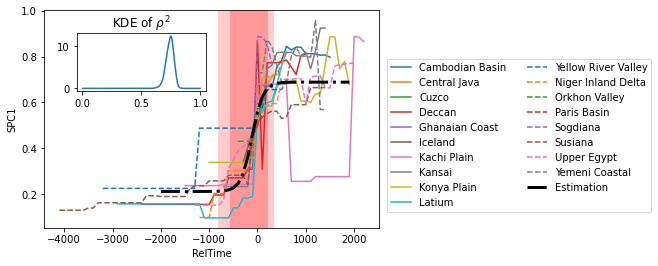

In [62]:
fig, ax1 = plt.subplots()
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2, 0.6, 0.3, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
style ="-"

for N in sorted(list(set(Cutout_DF["NGA"]))):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]

      # some abbreviations
    if N=="Middle Yellow River Valley":
        name = "Yellow River Valley"
    elif N == "Yemeni Coastal Plain":
        name = "Yemeni Coastal"
    else:
        name = N
        
    print(N)
    print(DF["RelTime"])
    ax1.plot(DF["RelTime"],   
             DF["SPC1"], style,label=name)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    if N == "Latium":
        style = "--"
    
ax1.plot(TimeRange, New_Fit, "-.",label="Estimation", c = "k", linewidth=3)
lgd = ax1.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
ax1.set_ylabel("SPC1")
ax1.set_xlabel("RelTime")
ax1.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
ax1.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
ax1.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)

ax2.plot(np.arange(0.0,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.0,1,0.001)))
ax2.set_title(r'KDE of $\rho^2$')

plt.savefig("Cutout_Logistic_Times_Inset.pdf",bbox_extra_artists=(lgd,),dpi=300,bbox_inches='tight')
plt.show()

In [63]:
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)), 
      "years. The interval's start and end times are", np.round(T1_scaled), "and", np.round(T2_scaled),
      "The lower boundary's uncertainty is", np.round(T1_start_scaled), "and the upper boundary's uncertainty is", 
     np.round(T2_end_scaled), "years. Thus, the upper estimate for the time range is", np.round(T2_end_scaled-T1_start_scaled), "years.")

Most of the cultural evolution takes place in a time interval of  772.0 years. The interval's start and end times are -563.0 and 210.0 The lower boundary's uncertainty is -828.0 and the upper boundary's uncertainty is 332.0 years. Thus, the upper estimate for the time range is 1160.0 years.
